# TAIAOexp

### Evaluation of explanation quality: saliency maps

Jesús Antoñanzas, under the supervision of Dr. Alvin Jia

<p float="left">
  <img src="https://www.bourses-etudiants.ma/wp-content/uploads/2018/06/University-of-Waikato-logo.png" alt="drawing" style="width:300px;"/>
  
  <img src="https://taiao.ai/img/6825_TAIAO_logo_1000x320.jpg" alt="drawing" style="width:250px;"/>
</p>

In this notebook, we are going to explore how we can use TAIAOexp to compare image explanation methods.

## 1. Explaining synthetic image data

In this section, we are going to 
1. Generate image data with available g.t. explanations using the 'seneca' method.
2. Create and train a pytorch classifier that will learn to recognize the pattern in the images.
3. Generate explanations with some model agnostic methods and evaluate them w.r.t. the ground truth explanations.

In [1]:
%cd ../../..

/home/ajia/TAIAOexp


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from math import floor

from TAIAOexp.saliencyMap import gen_data_sm

### 1.1. Generating the data

In [4]:
X, y, exps, pat = gen_data_sm(method='seneca', nSamples=6000, randomState=7)

Text(0.5, 1.0, 'Explanation')

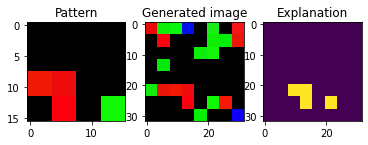

In [8]:
i = 2
fig, axs = plt.subplots(1, 3)
axs[0].imshow(pat)
axs[0].set_title('Pattern')
axs[1].imshow(X[i])
axs[1].set_title('Generated image')
axs[2].imshow(exps[i])
axs[2].set_title('Explanation')

### 1.2. Declaring and training the model

Declare a simple LeNet variant and its training routine.

In [9]:
class FCNN(nn.Module):
    """ Basic NN for image classification. """

    def __init__(self, imH, imW, cellH):
        super(FCNN, self).__init__()
        stride = 1
        kSize = 5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=kSize, stride=stride)
        self.H1, self.W1 = floor(((imH - kSize) / stride) + 1), floor(((imW - kSize) / stride) + 1)
        self.conv2 = nn.Conv2d(6, 3, kernel_size=kSize, stride=stride)
        self.H2, self.W2 = floor(((self.H1 - kSize) / stride) + 1), floor(((self.W1 - kSize) / stride) + 1)
        self.conv3 = nn.Conv2d(3, 1, kernel_size=kSize, stride=stride)
        self.H3, self.W3 = floor(((self.H2 - kSize) / stride) + 1), floor(((self.W2 - kSize) / stride) + 1)
        self.fc1 = nn.Linear(self.H3 * self.W3, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        if len(x.shape) == 3:
            # single instance, add the batch dimension
            print(x.shape)
            x = x.view(-1, x.shape[2], x.shape[1], x.shape[0])
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.shape[0], -1)))
        x = self.fc2(x)
        return x
    
# sample training function for binary classification
def train_net(model, X, y, XVal, yVal, randomState=888):
    """ X: FloatTensor, y: LongTensor """
    torch.manual_seed(randomState)
    batchSize = 50
    nEpochs = 100
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    bestValAcc = -np.inf
    for epoch in range(nEpochs):
        model.train()
        for batch in range(int(len(X) / batchSize)):
            XBatch = X[batch:batch + batchSize]
            yBatch = y[batch:batch + batchSize]
            model.zero_grad()
            out = model(XBatch)
            loss = criterion(out, yBatch)
            loss.backward()
            optimizer.step()
        model.eval()
        avgLoss = 0
        avgAcc = 0
        for batch in range(int(len(X) / batchSize)):
            XBatch = X[batch:batch + batchSize]
            yBatch = y[batch:batch + batchSize]
            out = model(XBatch)
            loss = criterion(out, yBatch)
            avgLoss += loss.item()
            preds = F.softmax(out, dim=-1).argmax(dim=1)
            acc = accuracy_score(yBatch, preds.detach().numpy())
            avgAcc += acc
        
        avgValLoss = 0
        avgValAcc = 0
        for batch in range(int(len(XVal) / batchSize)):
            XBatch = XVal[batch:batch + batchSize]
            yBatch = yVal[batch:batch + batchSize]
            out = model(XBatch)
            loss = criterion(out, yBatch)
            avgValLoss += loss.item()
            preds = F.softmax(out, dim=-1).argmax(dim=1)
            acc = accuracy_score(yBatch, preds.detach().numpy())
            avgValAcc += acc
        
        avgValAcc /= int(len(XVal) / batchSize)
        avgLoss /= int(len(X) / batchSize)
        avgAcc /= int(len(X) / batchSize)
        
        # early stoppage
        if avgValAcc >= bestValAcc:
            bestValAcc = avgValAcc
        else:
            break

    return model, avgLoss, avgAcc

We cast the images to torch.Tensor type and get train, validation and test splits.

In [10]:
XTrain, XTest, yTrain, yTest, expsTrain, expsTest = train_test_split(X, y, exps, train_size=0.8, random_state=7)
XTrain, XVal, yTrain, yVal, expsTrain, expsVal = train_test_split(XTrain, yTrain, expsTrain, train_size=0.6, random_state=7)

XTrain = torch.FloatTensor(XTrain).permute(0, 3, 1, 2)
yTrain = torch.LongTensor(yTrain)
XVal = torch.FloatTensor(XVal).permute(0, 3, 1, 2)
yVal = torch.LongTensor(yVal)
XTest = torch.FloatTensor(XTest).permute(0, 3, 1, 2)
yTest = torch.LongTensor(yTest)

and train the network

In [11]:
nFeatures = len(XTrain[0].flatten())
model, trLoss, trAcc = train_net(FCNN(imH=32, imW=32, cellH=4), XTrain, yTrain, XVal, yVal, randomState=7)

In [13]:
print(f'Tr. loss: {round(trLoss, 3)}, Tr. accuracy: {round(trAcc, 3)}')
print(f'Validation F1: {round(f1_score(yVal, F.softmax(model(torch.FloatTensor(XVal)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')
print(f'Test F1: {round(f1_score(yTest, F.softmax(model(torch.FloatTensor(XTest)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')

Tr. loss: 0.018, Tr. accuracy: 0.994
Validation F1: 0.667
Test F1: 0.678


### 1.3. Generating and evaluating explanations

With the model trained on the synthetic images, we generate explanations (with Captum, but feel free to use other methods!). First, declare the explainers:

In [15]:
from captum.attr import GradientShap, IntegratedGradients, Occlusion, DeepLift, Lime, GuidedBackprop, GuidedGradCam

gradShap = GradientShap(model)
intGrad = IntegratedGradients(model)
occlusion = Occlusion(model)
deepLift = DeepLift(model)
lime = Lime(model)
guidedBackProp = GuidedBackprop(model)
guidedGradCAM = GuidedGradCam(model, model.conv3)

And define a function to obtain the explanations from different methods:

In [36]:
from TAIAOexp.utils._arrays import _minmax_normalize_array

def get_attributions(data, labels, explainer, params=None):
    """  
    :param data: (Tensor) data to explain
    :param labels: (Tensor) class labels w.r.t which we want to compute the attributions
    :param explainer: (captum.attr method) initialised explainer
    :param params: (dict) parameters for the .attribute method of the explainer 
    :return: ndarray of shape with attributions
    """
    
    if params is None:
        params = {}
    attributions = []
    for image, target in zip(data, labels):
        if len(image.shape) == 3:
            image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
        attr = explainer.attribute(image, target=target, **params)
        attr = attr.squeeze()
        if len(attr.shape) == 3:
            attr = np.transpose(attr.squeeze().cpu().detach().numpy(), (1, 2, 0))
            # mean pool channel attributions
            attr = np.mean(attr, axis=2)
            # attr = attr.mean(dim=2)
        elif len(attr.shape) != 2:
            raise ValueError(f'Attribution shape {attr.shape} is not valid.')

        # viz._normalize_image_attr(tmp, 'absolute_value', 10)
        attributions.append(_minmax_normalize_array(attr))

    return np.array(attributions)

In [ ]:
from TAIAOexp.utils._explanation.images import torch_pixel_attributions

cellH, cellW = 8, 8
imH, imW = 32, 32

# takes a few minutes to run
gradShapExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], gradShap, {'baselines': torch.zeros((1, 3, imH, imW))})
intGradExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], intGrad)
deepLiftExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], deepLift)
occlusionExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], occlusion, {'baselines': 0, 'sliding_window_shapes': (3, cellH, cellW)})
gBackPropExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], guidedBackProp)
gGradCAMExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], guidedGradCAM)

with open('TAIAOexp/_demos/notebooks/temp/expsSynth.pickle', 'wb') as handle:
    pickle.dump([gradShapExpsTest, intGradExpsTest, deepLiftExpsTest, occlusionExpsTest, gBackPropExpsTest, gGradCAMExpsTest], handle)

In [40]:
with open('TAIAOexp/_demos/notebooks/temp/expsSynth.pickle', 'rb') as handle:
    gradShapExpsTest, intGradExpsTest, deepLiftExpsTest, occlusionExpsTest,\
        gBackPropExpsTest, gGradCAMExpsTest = pickle.load(handle)

And we can evaluate the explanations. We set the binarization threshold for the generated explanations to 0.5 because we only want high values to count.

In [55]:
from TAIAOexp.saliencyMap import saliency_map_scores

metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']
gradShapScores = saliency_map_scores(expsTest[yTest == 1], gradShapExpsTest, metrics=metrics, binThreshold=0.5)
intGradScores = saliency_map_scores(expsTest[yTest == 1], intGradExpsTest, metrics=metrics, binThreshold=0.5)
deepLiftScores = saliency_map_scores(expsTest[yTest == 1], deepLiftExpsTest, metrics=metrics, binThreshold=0.5)
occlusionScores = saliency_map_scores(expsTest[yTest == 1], occlusionExpsTest, metrics=metrics, binThreshold=0.5)
gBackPropScores = saliency_map_scores(expsTest[yTest == 1], gBackPropExpsTest, metrics=metrics, binThreshold=0.5)
gGradCAMScores = saliency_map_scores(expsTest[yTest == 1], gGradCAMExpsTest, metrics=metrics, binThreshold=0.5)

scores = pd.DataFrame(data=[gradShapScores, intGradScores, deepLiftScores, 
                            occlusionScores, gBackPropScores, gGradCAMScores], columns=metrics)
scores['technique'] = ['gradSHAP', 'intGrad', 'deepLift', 'occlusion', 'guidedBackProp', 'guidedGradCAM']
scores

,auc,fscore,prec,rec,cs,technique
0,0.524833,0.140602,0.154963,0.467941,0.253345,gradSHAP
1,0.524201,0.142759,0.155039,0.466272,0.253261,intGrad
2,0.529007,0.147402,0.154159,0.464376,0.253112,deepLift
3,0.515721,0.105970,0.064782,0.429839,0.227287,occlusion
4,0.498947,0.116112,0.066204,0.678474,0.245746,guidedBackProp
5,0.498193,0.075818,0.059877,0.383596,0.246095,guidedGradCAM


From here, we can build a more complex explanation evaluation pipeline. Suppose that, given some explainer architecture and model, we want to measure how the influence of some explainer hyperparameters influence the quality of their generated explanations.

In [ ]:
def eval_explainer(model, explainerMethod, explainerConfigs, data, labels, trueExps, metrics):
    """ 
    :param model: pytorch model
    :param explainerMethod: (str) explainer to use
    :param explainerConfig: (array like of dict) explainer hyperparameter values (see Captum docs)
    :param data: (Tensor) data to explain
    :param labels: (Tensor) labels w.r.t. which we compute the explanations
    :param trueExps: (ndarray) ground truth explanations
    :param metrics: (array-like of str) metrics to compute
    """
    scores = {met: [] for met in metrics}
    for config in explainerConfigs:
        exps = torch_pixel_attributions(model, XTest[yTest == 1], yTest[yTest == 1], method=explainerMethod, **config)
        evals = saliency_map_scores(trueExps, exps, metrics = metrics)
        for i, score in enumerate(evals):
            scores[metrics[i]].append(score)
    return scores

for example, given this configuration of deepLift: